# 4. Optimizations

Currently, the model is experiencing the [checkerboard problem](https://distill.pub/2016/deconv-checkerboard/). 
<br/>
<center><img src="images/shoe_maybe.png" /></center>
<br/>
Thankfully, we have a few tricks up our generated T-shirt sleeve to resolve this and generally improve the performance of the model.
<br/>
<br/>

#### Learning Objectives

The goals of this notebook are to:
* Implement Group Normalization
* Implement GELU
* Implement Rearrange Pooling
* Implement Sinusoidal Position Embeddings
* Define a reverse diffusion function to emulate `p`
* Attempt to generate articles of clothing (again)

Like before, let's use fashionMIST to experiment:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

# Visualization tools
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz
from IPython.display import Image

torch.set_float32_matmul_precision('high')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Notebook is using: {device}")

Notebook is using: cuda


In [3]:
# some helper functions
def load_fashionMNIST(data_transform, train=True):
    return torchvision.datasets.FashionMNIST(
        "./data/",
        download=True,
        train=train,
        transform=data_transform
    )

def load_transformed_fashionMNIST(img_size, batch_size):
    data_transforms = [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),   # Scales data into [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t*2) - 1)  # Scale between [-1, 1]
    ]
    
    data_transform = transforms.Compose(data_transforms)
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)
    data = torch.utils.data.ConcatDataset([train_set, test_set])
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    return data, dataloader

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu()))

In [4]:
IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**DDPM(Denoising Diffusion Probabilistic Model)**

In [5]:
class DDPM:
    def __init__(self, B, device):
        self.B = B
        self.T = len(B)
        self.device = device

        # Forward diffusion variables
        self.a = 1.0 - self.B
        self.a_bar = torch.cumprod(self.a, dim=0)
        self.sqrt_a_bar = torch.sqrt(self.a_bar)               # Mean coefficient
        self.sqrt_one_minus_a_bar = torch.sqrt(1 - self.a_bar) # St. Dev. Coefficient

        # Reverse diffusion variables
        self.sqrt_a_inv = torch.sqrt(1 / self.a)
        self.pred_noise_coeff = (1 - self.a) / torch.sqrt(1 - self.a_bar)

    def q(self, x_0, t):
        """
        The forward diffusion process
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        t = t.int()
        noise = torch.randn_like(x_0)
        sqrt_a_bar_t = self.sqrt_a_bar[t, None, None, None]
        sqrt_one_minus_a_bar_t = self.sqrt_one_minus_a_bar[t, None, None, None]

        x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
        return x_t, noise

    def get_loss(self, model, x_0, t, *model_args):
        x_noisy, noise = self.q(x_0, t)
        noise_pred = model(x_noisy, t, *model_args)
        return F.mse_loss(noise, noise_pred)

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        """
        The reverse diffusion process
        Returns the an image with the noise from time t removed and time t-1 added.
        model: the model used to remove the noise
        x_t: the noisy image at time t
        t: timestep
        model_args: additional arguments to pass the model
        """
        t = t.int()
        pred_noise_coeff_t = self.pred_noise_coeff[t]
        sqrt_a_inv_t = self.sqrt_a_inv[t]
        u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
        if t[0] == 0:    # All t values should be the same
            return u_t   # Reverse diffusion complete!
        else:
            B_t = self.B[t - 1]  # Apply noise from the previous timestep
            new_noise = torch.randn_like(x_t)
            return u_t + torch.sqrt(B_t) * new_noise

    @torch.no_grad()
    def sample_images(self, model, img_ch, img_size, ncols, *model_args, axis_on=False):
        # Noise to generate the image from
        x_t = torch.randn((1, img_ch, img_size, img_size), device=self.device)
        plt.figure(figsize=(8, 8))
        hidden_rows = self.T / ncols
        plot_number = 1

        # Go from T to 0 removing and adding noise until t=0
        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=self.device).float()
            e_t = model(x_t, t, *model_args)
            x_t = self.reverse_q(x_t, t, e_t)
            if i % hidden_rows == 0:
                ax = plt.subplot(1, ncols + 1, plot_number)
                if not axis_on:
                    ax.axis("off")
                show_tensor_image(x_t.detach().cpu())
                plot_number += 1
        plt.show()

In [6]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = DDPM(B, device)

## 4.1 Group Normalization and GELU

The first improvement we will look at is optimizing our standard convolution process. We will be reusing this block many times throughout our neural network, so it is an important piece to get right.

### 4.1.1 Group Normalization

[Batch Normalization](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) converts the output of each kernel channel to a [z-score](https://www.nlm.nih.gov/oet/ed/stats/02-910.html). It does this by calculating the mean and standard deviation across a batch of inputs. This is ineffective if the batch size is small.

On the other hand, [Group Normalization](https://arxiv.org/pdf/1803.08494.pdf) normalizes the output of a group of kernels for each sample image, effectively "grouping" a set of features.

<center><img src="images/groupnorm.png" /></center>

Considering color images have multiple color channels, this can have an interesting impact on the output colors of generated images. Try experimenting to see the effect!

Learn more about normalization techniques in this [blog post](https://medium.com/techspace-usict/normalization-techniques-in-deep-neural-networks-9121bf100d8) by Aakash Bindal.


**References**

* [Batch Normalization - Towards Data Science](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)
* [Z-score - NLM.gov](https://www.nlm.nih.gov/oet/ed/stats/02-910.html)
* [Group Normalization - arXiv Paper](https://arxiv.org/pdf/1803.08494.pdf)
* [Normalization Techniques in Deep Neural Networks - Medium Blog](https://medium.com/techspace-usict/normalization-techniques-in-deep-neural-networks-9121bf100d8)


### 4.1.2 GELU

[ReLU](https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning) is a popular choice for an activation function because it is computationally quick and easy to calculate the gradient for. Unfortunately, it isn't perfect. When the bias term becomes largely negative, a ReLU neuron ["dies"](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks) because both its output and gradient are zero.

At a slight cost in computational power, [GELU](https://arxiv.org/pdf/1606.08415.pdf) seeks to rectify the rectified linear unit by mimicking the shape of the ReLU function while avoiding a zero gradient.

In this small example with FashionMNIST, it is unlikely we will see any dead neurons. However, the larger a model gets, the more likely it can face the dying ReLU phenomenon.

**References**

* [ReLU – kaggle.com](https://www.kaggle.com/code/dansbecker/rectified-linear-units-relu-in-deep-learning)
* [What is the dying ReLU problem – Data Science Stack Exchange](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks)
* [GELU – arXiv paper](https://arxiv.org/pdf/1606.08415.pdf)

In [7]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 4.2 Rearrange pooling

In the previous notebook, we used [Max Pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) to reduce the size of our latent image by half. But is that the optimal approach? There are [several types of pooling layers](https://pytorch.org/docs/stable/nn.html#pooling-layers), such as Min Pooling and Average Pooling. Instead of choosing one ourselves, what if we let the neural network determine what features are most important?

This is where the [einops](https://einops.rocks/1-einops-basics/) library and the [Rearrange](https://einops.rocks/api/rearrange/) layer come into play. With einops, we can define layers using readable, flexible patterns. Parentheses `()` are used to group variables that are multiplied together.

Take this example:

`Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)`

Here's what the variables represent:

* `b`: batch dimension
* `c`: channel dimension
* `h`: height dimension
* `w`: width dimension

We also define `p1` and `p2` as `2`. The pattern before the arrow `"b c (h p1) (w p2)"` tells us to split the height and width dimensions into smaller patches. The pattern after the arrow `"b (c p1 p2) h w"` rearranges those patches by stacking them into the channel dimension.

The code block below sets up a `test_image` you can experiment with. Try swapping `h` with `p1` on the left side of the arrow—what changes? What happens when you swap `w` with `p2`? Or when you change `p1` from `2` to `3`?

**References**

* [Max Pooling – PyTorch Documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)
* [Various Pooling Layers – PyTorch Documentation](https://pytorch.org/docs/stable/nn.html#pooling-layers)
* [einops Basics – einops.rocks](https://einops.rocks/1-einops-basics/)
* [Rearrange – einops.rocks](https://einops.rocks/api/rearrange/)


In [8]:
from einops.layers.torch import Rearrange

rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [13, 15, 17],
          [25, 27, 29]],

         [[ 2,  4,  6],
          [14, 16, 18],
          [26, 28, 30]],

         [[ 7,  9, 11],
          [19, 21, 23],
          [31, 33, 35]],

         [[ 8, 10, 12],
          [20, 22, 24],
          [32, 34, 36]]]])

Next, we can pass this through our `GELUConvBlock` to let the neural network decide how it wants to weigh the values within our "pool". Notice the `4*in_chs` as a parameter of the `GELUConvBlock`? This is because the channel dimension is now p1 * p2 larger.

In [9]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

We now have the components to redefine our `DownBlock`s and `UpBlock`s. Multiple `GELUConvBlock`s have been added to help combat the checkerboard problem.

In [10]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [11]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

## 4.3 Time Embeddings

The better the model understands the timestep it is in for the reverse diffusion process, the better it will be able to correctly identify the added noise. In the previous notebook, we created an embedding for `t/T`. Can we help the model interpret this better?

Before diffusion models, this was a problem that plagued natural language processing. For long dialogues, how can we capture where we are? The goal was to find a way to uniquely represent a large range of discrete numbers with a small number of continuous numbers. Using a single float is ineffective since the neural network will interpret timesteps as continuous rather than discrete. [Researchers](https://arxiv.org/pdf/1706.03762.pdf) ultimately settled on a sum of sines and cosines.

For an excellent explanation for why this works and how this technique was likely developed, please refer to Jonathan Kernes' [Master Positional Encoding](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3).

**References**

* [Attention Is All You Need – Arxiv Paper](https://arxiv.org/pdf/1706.03762.pdf)
* [Master Positional Encoding – Towards Data Science](https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3)

In [12]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [13]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

## 4.4 Residual Connections

The last trick to eliminate the checkerboard problem is to add more residual or skip connections. We can create a `ResidualConvBlock` for our initial convolution. We could add residual connections in other places as well, such as within our "DownBlocks" and "UpBlocks".

In [14]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [16]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777


Finally, it's time to train the model. Let's see if all these changes made a difference.

W1014 12:11:46.465000 60896 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 0 | step 000 Loss: 1.0518392324447632 


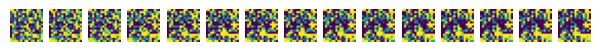

Epoch 0 | step 100 Loss: 0.17622679471969604 


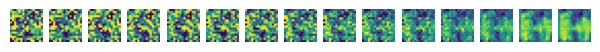

Epoch 0 | step 200 Loss: 0.1336493194103241 


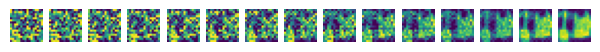

Epoch 0 | step 300 Loss: 0.10792908072471619 


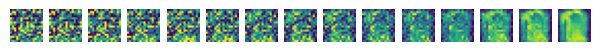

Epoch 0 | step 400 Loss: 0.09677410870790482 


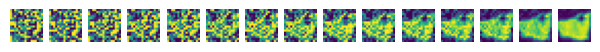

Epoch 0 | step 500 Loss: 0.10750266164541245 


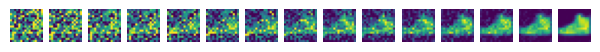

Epoch 1 | step 000 Loss: 0.12235641479492188 


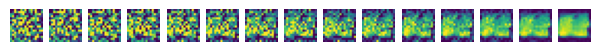

Epoch 1 | step 100 Loss: 0.13958127796649933 


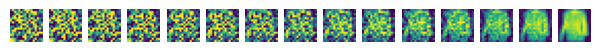

Epoch 1 | step 200 Loss: 0.11018811166286469 


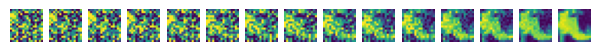

Epoch 1 | step 300 Loss: 0.10125745087862015 


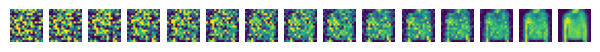

Epoch 1 | step 400 Loss: 0.10865895450115204 


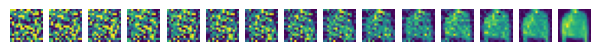

Epoch 1 | step 500 Loss: 0.11225356161594391 


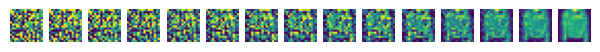

Epoch 2 | step 000 Loss: 0.09597432613372803 


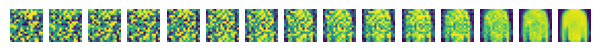

Epoch 2 | step 100 Loss: 0.09438153356313705 


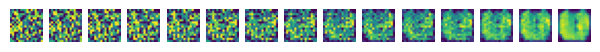

Epoch 2 | step 200 Loss: 0.11184343695640564 


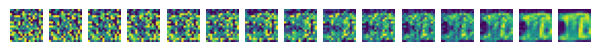

Epoch 2 | step 300 Loss: 0.11436544358730316 


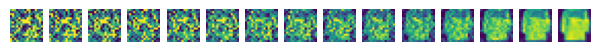

Epoch 2 | step 400 Loss: 0.09746186435222626 


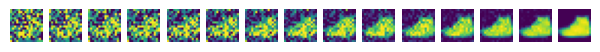

Epoch 2 | step 500 Loss: 0.10450486838817596 


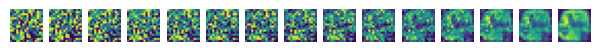

Epoch 3 | step 000 Loss: 0.09016886353492737 


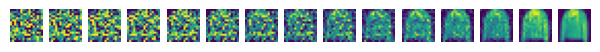

Epoch 3 | step 100 Loss: 0.0882318764925003 


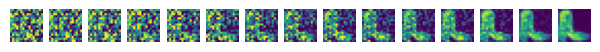

Epoch 3 | step 200 Loss: 0.0836634561419487 


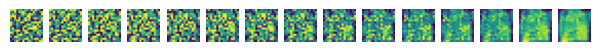

Epoch 3 | step 300 Loss: 0.08162093162536621 


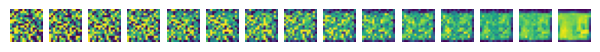

Epoch 3 | step 400 Loss: 0.09243543446063995 


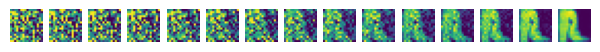

Epoch 3 | step 500 Loss: 0.10626071691513062 


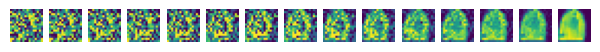

Epoch 4 | step 000 Loss: 0.10064959526062012 


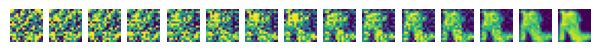

Epoch 4 | step 100 Loss: 0.1018071323633194 


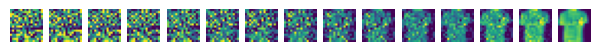

Epoch 4 | step 200 Loss: 0.09040706604719162 


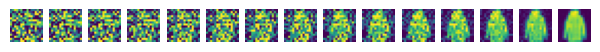

Epoch 4 | step 300 Loss: 0.10575403273105621 


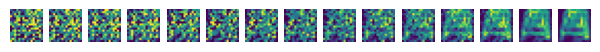

Epoch 4 | step 400 Loss: 0.08306759595870972 


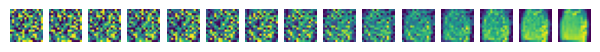

Epoch 4 | step 500 Loss: 0.09189853817224503 


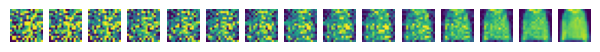

In [17]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 50

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = ddpm.get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

How about a closer look? Can you recognize a shoe, a purse, or a shirt?

<Figure size 800x800 with 0 Axes>

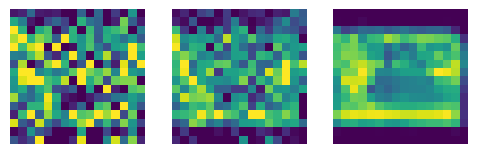

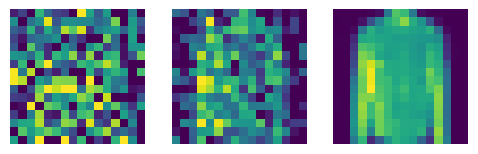

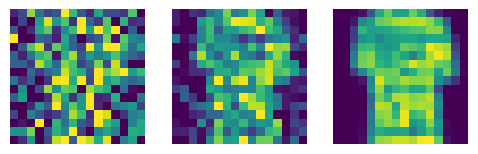

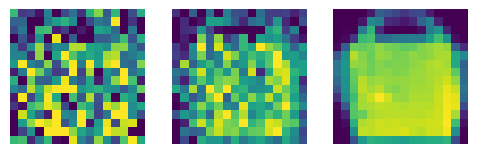

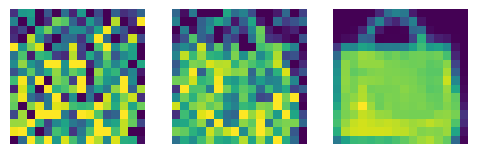

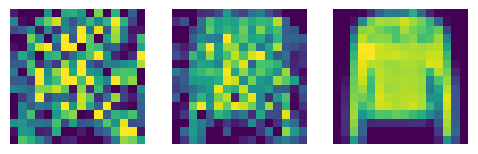

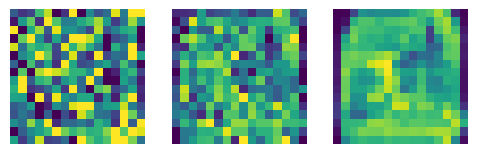

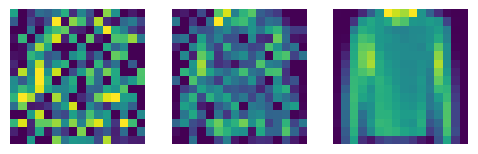

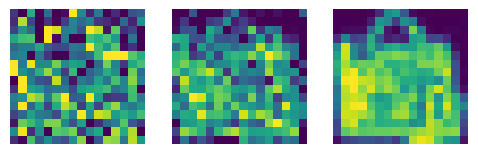

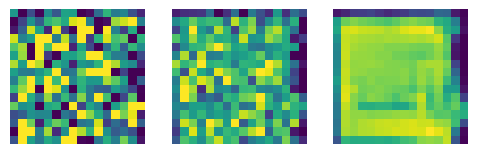

In [17]:
model.eval()
plt.figure(figsize=(8,8))
ncols = 3 # Should evenly divide T
for _ in range(10):
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

## 4.5 Next

If you don't see a particular class such as a shoe or a shirt, try running the above code block again. Currently, our model does not accept category input, so the user can't define what kind of output they would like. Where's the fun in that?

In the next notebook, we will finally add a way for users to control the model!

In [18]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}